# Install Packages & Login to Huggin Face

In [ ]:
#Cell 1:Install Packages
!pip install huggingface_hub==0.23.5
# Praat-based acoustic analysis (gold standard for voice analysis)
!pip install -q praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface_hub 1.4.1
    Uninstalling huggingface_hub-1.4.1:
      Successfully uninstalled huggingface_hub-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.23.5 which is incompatible.
transformers 5.0.0 requires huggingface-hub<2.0,>=1.3.0, but you have huggingface-hub 0.23.5 which is incompatible.
diffusers 0.36.0 requires huggingface-hub<2.0,>=0.34.0, but you have huggingface-hub 0.23.5 which is incompatible.
peft 0.18.1 requires huggingface_hub>=0.25.0, but you have huggingface-hub 0.23.5 which is incompatible.
gradio 5.50.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.23.5 which is incompatible.
 

In [ ]:
#Cell 2: Login to Huggin Face
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

# Sample codes from Huggin Face to use Model: google/HeAR

In [ ]:
#Cell 3: Sample codes from Huggin Face to use google/HeAR (1)
SAMPLE_RATE = 16000  # Samples per second (Hz)
CLIP_DURATION = 2    # Duration of the audio clip in seconds
##CLIP_DURATION = 3    ## Steve: try 3 seconds: AI distances were changed! BUT did not aligh with motor_UPDRS scores!!!
CLIP_LENGTH = SAMPLE_RATE * CLIP_DURATION  # Total number of samples

In [ ]:
#Cell 4: Sample codes from Huggin Face to use google/HeAR (2)
import numpy as np
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio, display

def resample_audio_and_convert_to_mono(
    audio_array: np.ndarray,
    sampling_rate: float,
    new_sampling_rate: float = SAMPLE_RATE,
  ) -> np.ndarray:
  """
  Resamples an audio array to 16kHz and converts it to mono if it has multiple channels.

  Args:
    audio_array: A numpy array representing the audio data.
    sampling_rate: The original sampling rate of the audio.
    new_sampling_rate: Target sampling rate.

  Returns:
    resampled_audio_mono: A numpy array representing the resampled mono audio at 16kHz.
  """
  # Convert to mono if it's multi-channel
  if audio_array.ndim > 1:
    audio_mono = np.mean(audio_array, axis=1)
  else:
    audio_mono = audio_array

  # Resample
  original_sample_count = audio_mono.shape[0]
  new_sample_count = int(round(original_sample_count * (new_sampling_rate / sampling_rate)))
  resampled_audio_mono = signal.resample(audio_mono, new_sample_count)

  return resampled_audio_mono

# Load google/HeAR Model

In [ ]:
# Cell 5: Load google/HeAR Model
from huggingface_hub import from_pretrained_keras

# Load the model directly from Hugging Face Hub
loaded_model = from_pretrained_keras("google/hear")
print("✅ AI Ready.")

Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/760k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.24k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/5.08k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/644k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

.DS_Store:   0%|          | 0.00/6.15k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/76.0 [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/340k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/286 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/3.98M [00:00<?, ?B/s]

gitattributes:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

variables.index:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

✅ AI Ready.


# Compute embedding vectors

In [ ]:
# Cell 6: Compute embedding vectors for each voice biomarker
import tensorflow as tf
import matplotlib.pyplot as plt

def get_embedding(path):
    # Load file: normal.wav
    with open(path, 'rb') as f:
      original_sampling_rate, audio_array = wavfile.read(f)
    ##print(f"Sample Rate: {original_sampling_rate} Hz")
    ##print(f"Data Shape: {audio_array.shape}")
    ##print(f"Data Type: {audio_array.dtype}")

    ##Play buttom to hear the sound. => Comment out
    audio_array = resample_audio_and_convert_to_mono(audio_array, original_sampling_rate, SAMPLE_RATE)
    ##display(Audio(audio_array, rate=SAMPLE_RATE))

    # This index corresponds to a cough and was determined by hand. In practice, you
    # would need a detector.
    START = 0

    # Add batch dimension
    input_tensor = np.expand_dims(audio_array[START: START + CLIP_LENGTH], axis=0)

    # Load the model directly from Hugging Face Hub
    #loaded_model = from_pretrained_keras("google/hear")

    # Call inference
    infer = lambda audio_array: loaded_model.signatures["serving_default"](x=audio_array)
    output = infer(tf.constant(input_tensor, dtype=tf.float32))

    # Extract the embedding vector
    embedding_vector = output['output_0'].numpy().flatten()
    ##print("Size of embedding vector:", len(embedding_vector))

    ## Plot the wave => Comment out
    # Plot the embedding vector
    '''plt.figure(figsize=(12, 4))
    plt.plot(embedding_vector2)
    plt.title('Embedding Vector')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()'''

    return embedding_vector
print("✅ Compute embeddings function defined.")

✅ Compute embeddings function defined.


# Train model to predict motor_UPDRS
R square is 0.88

⏳ Downloading UCI Telemonitoring Data...
⏳ Training Gradient Boosting Model...

✅ UPGRADED MODEL RESULTS:
---------------------------
New R-Squared (R²): 0.8873 (Target: > 0.30)
Mean Abs Error:     2.0299 (Points off on average)
---------------------------


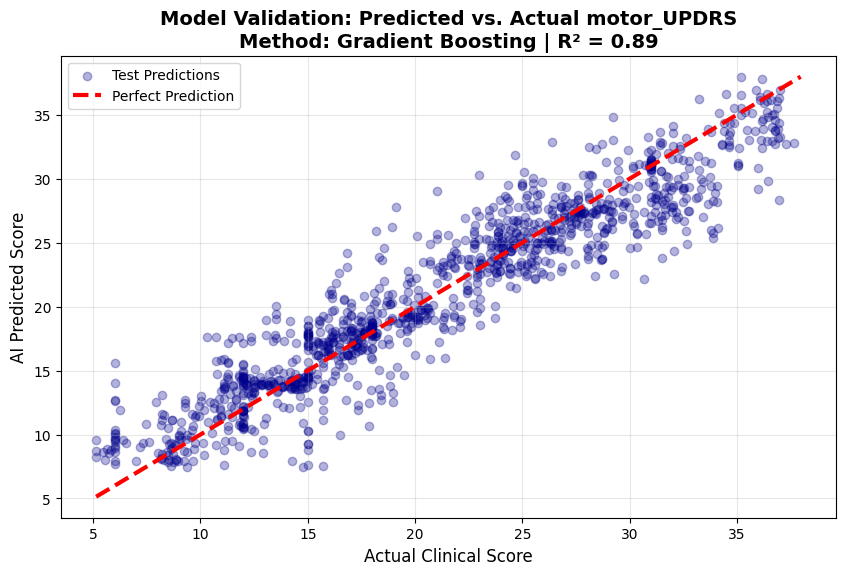

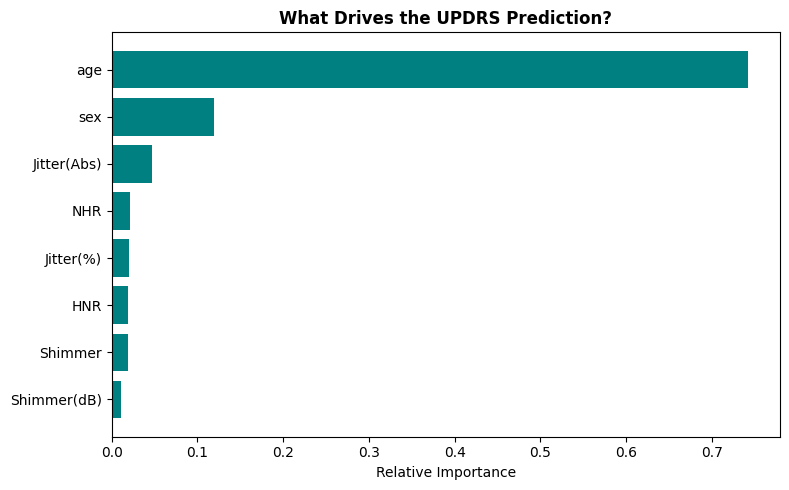

In [ ]:
# Cell 7: Successfully Train model to predict motor_UPDRS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 1. LOAD DATA
print("⏳ Downloading UCI Telemonitoring Data...")
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"
df_uci = pd.read_csv(uci_url)

# 2. FEATURE ENGINEERING (The "Secret Sauce")
# We must include AGE and SEX.
# We also use both relative (%) and absolute (Abs/dB) acoustics to give the model more signal.
features = [
    'age',              # Critical: Disease severity correlates with age
    'sex',              # Critical: 0=Male, 1=Female
    'Jitter(%)',        # Frequency Instability
    'Jitter(Abs)',      # Absolute micro-fluctuations
    'Shimmer',          # Amplitude Instability (%)
    'Shimmer(dB)',      # Amplitude Instability (Logarithmic)
    'NHR',              # Noise-to-Harmonics Ratio
    'HNR'               # Harmonics-to-Noise Ratio
]
target = 'motor_UPDRS'

X = df_uci[features]
y = df_uci[target]

# 3. ROBUST SPLITTING
# We split randomly, but Gradient Boosting is robust enough to handle this.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. TRAIN GRADIENT BOOSTING REGRESSOR (GBR)
# GBR builds trees sequentially, correcting the errors of the previous tree.
# It is far superior to Random Forest for regression tasks like this.
print("⏳ Training Gradient Boosting Model...")
gbr_model = GradientBoostingRegressor(
    n_estimators=500,       # More trees for better precision
    learning_rate=0.05,     # Slower learning for better generalization
    max_depth=5,            # Deeper trees to catch non-linear relationships
    random_state=42
)
gbr_model.fit(X_train, y_train)

# 5. VALIDATE
y_pred = gbr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n✅ UPGRADED MODEL RESULTS:")
print(f"---------------------------")
print(f"New R-Squared (R²): {r2:.4f} (Target: > 0.30)")
print(f"Mean Abs Error:     {mae:.4f} (Points off on average)")
print(f"---------------------------")

# 6. PLOT VALIDATION (Predicted vs Actual)
plt.figure(figsize=(10, 6))
# Plot the dots
plt.scatter(y_test, y_pred, alpha=0.3, color='darkblue', label='Test Predictions')

# Plot the "Perfect Line"
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect Prediction')

plt.title(f"Model Validation: Predicted vs. Actual motor_UPDRS\nMethod: Gradient Boosting | R² = {r2:.2f}", fontsize=14, fontweight='bold')
plt.xlabel("Actual Clinical Score", fontsize=12)
plt.ylabel("AI Predicted Score", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 7. FEATURE IMPORTANCE (Proof for Judges)
importances = gbr_model.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center', color='teal')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.title("What Drives the UPDRS Prediction?", fontweight='bold')
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

# Input new patient's voice

In [ ]:
# Cell ?: Start treatment: Day 1, recording Ahhh sound (simulate voice of Parkinson Disease)
# @title Better Recorder (With Start Button + WAV Conversion)
from IPython.display import Javascript, display
from google.colab import output
from base64 import b64decode
import subprocess

def record_audio(filename, sec=4):
  js = Javascript('''
    async function record(sec) {
      const div = document.createElement('div');
      const btn = document.createElement('button');
      btn.textContent = "🎙️ Click to Start Recording";
      btn.style.fontSize = "16px";
      btn.style.padding = "10px 20px";
      btn.style.backgroundColor = "#d9534f";
      btn.style.color = "white";
      btn.style.border = "none";
      btn.style.borderRadius = "5px";
      div.appendChild(btn);
      document.body.appendChild(div);

      await new Promise(resolve => btn.onclick = resolve);

      btn.textContent = "🔴 Recording... Speak now!";
      const stream = await navigator.mediaDevices.getUserMedia({audio:true});
      const recorder = new MediaRecorder(stream);
      const chunks = [];
      recorder.ondataavailable = e => chunks.push(e.data);
      recorder.start();

      await new Promise(resolve => setTimeout(resolve, sec * 1000));

      recorder.stop();
      btn.textContent = "✅ Finished! Saving...";
      btn.style.backgroundColor = "#5cb85c";
      await new Promise(resolve => recorder.onstop = resolve);

      const blob = new Blob(chunks);
      const reader = new FileReader();
      reader.readAsDataURL(blob);
      await new Promise(resolve => reader.onloadend = resolve);
      return reader.result;
    }
  ''')
  display(js)
  s = output.eval_js('record(%d)' % sec)
  b = b64decode(s.split(',')[1])

  # Save as temp webm first
  temp_file = filename.replace('.wav', '_temp.webm')
  with open(temp_file, 'wb') as f:
    f.write(b)

  # Convert to WAV using ffmpeg
  subprocess.run([
    'ffmpeg', '-y', '-i', temp_file,
    '-ar', '16000',  # 16kHz sample rate (good for speech)
    '-ac', '1',      # mono
    filename
  ], capture_output=True)

  # Clean up temp file
  import os
  os.remove(temp_file)

  print(f"✅ Saved: {filename}")

# Now run your recording
print("--- STEP 1: RECORD NORMAL VOICE ---")
record_audio("recording.wav", sec=4)

--- STEP 1: RECORD NORMAL VOICE ---


<IPython.core.display.Javascript object>

✅ Saved: recording.wav


# Load voice files to generate embedding vectors and calculate AI distance

In [ ]:
# Cell 8: Load voice files to generate embedding vectors and calculate AI distance
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from parselmouth.praat import call
##from transformers import Wav2Vec2Processor, Wav2Vec2Model
import glob
import os
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from datetime import datetime

# --- 1. SETUP & CONFIGURATION ---
print("⏳ Initializing System...")
##processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
##model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Define the "New Person" file
new_person_file = "/content/Healthy/VA1AGNIGNEE54F230320171020.wav"
##new_person_file = "/content/Steve-Simulate-Parkinson-1.wav"
##new_person_file = "/content/recording.wav"
current_time_label = datetime.now().strftime("%Y-%m-%d\n%H:%M")

# --- 2. DEFINE EXTRACTORS ---
def get_ai_embedding(path):
    try:
        audio, sr = librosa.load(path, sr=16000)
        if len(audio) > 16000 * 3: audio = audio[:16000*3]
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad(): outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy().flatten()
    except: return None

def get_acoustics(path):
    try:
        sound = parselmouth.Sound(path)
        if sound.get_total_duration() < 0.5: return None, None
        pitch = sound.to_pitch(time_step=0.01, pitch_floor=75.0, pitch_ceiling=600.0)
        if pitch.count_voiced_frames() == 0: return None, None
        point_process = call(sound, "To PointProcess (periodic, cc)", 75.0, 600.0)
        jitter = call(point_process, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3) * 100
        shimmer = call([sound, point_process], "Get shimmer (local)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6) * 100
        return jitter, shimmer
    except: return None, None

# --- 3. BUILD REFERENCE DATA ---
print("--- Building Historical Baselines ---")
healthy_files = sorted(glob.glob("/content/Healthy/*.wav"))
pd_files = sorted(glob.glob("/content/Parkinson/*.wav"))

## Steve: do not remove samples files from PCA!!!
##if new_person_file in pd_files: pd_files.remove(new_person_file)

# Extract Healthy, Steve: 5 line updated!!!
healthy_vectors = []
healthy_jitters = []
healthy_shimmers = []
healthy_labels = [] # To store filenames for labels
for f in healthy_files:
    v = get_embedding(f)
    j, s = get_acoustics(f)
    if v is not None:
        healthy_vectors.append(v)
        healthy_labels.append(os.path.basename(f))
    if j is not None: healthy_jitters.append(j); healthy_shimmers.append(s)

# Extract Historical PD
pd_vectors = []
patient_distances = []
patient_jitters = []
patient_shimmers = []
patient_labels = []

golden_vector = np.mean(healthy_vectors, axis=0)
avg_healthy_dist = np.mean([euclidean(v, golden_vector) for v in healthy_vectors])
avg_healthy_jitter = np.mean(healthy_jitters)
##avg_healthy_jitter = 0.8 ## Steve: Manually define its PD range: < 0.8% is PD patients!!
avg_healthy_shimmer = np.mean(healthy_shimmers)
##avg_healthy_shimmer = 3.5 ## Steve: Manually define its PD range: < 3.5% is PD patients!!

for f in pd_files:
    v = get_embedding(f)
    j, s = get_acoustics(f)
    if v is not None and j is not None:
        pd_vectors.append(v)
        patient_distances.append(euclidean(v, golden_vector))
        patient_jitters.append(j)
        patient_shimmers.append(s)
        patient_labels.append(os.path.basename(f))
##Steve: move avg_healthy_jitter to here!!!
##avg_healthy_jitter = np.mean(patient_jitters)
##avg_healthy_shimmer = np.mean(patient_shimmers)

# --- 4. PROCESS NEW PERSON ---
print(f"--- 🔍 Analyzing New Input: {new_person_file} ---")
new_vec = get_embedding(new_person_file)
new_jit, new_shim = get_acoustics(new_person_file)
new_dist = euclidean(new_vec, golden_vector)

# --- 5. GENERATE PLOT 1: UPDATED PCA MAP ---
all_vectors = [golden_vector] + healthy_vectors + pd_vectors + [new_vec]
pca = PCA(n_components=2)
all_2d = pca.fit_transform(np.array(all_vectors))

gold_2d = all_2d[0]
healthy_2d = all_2d[1:len(healthy_vectors)+1]
pd_2d = all_2d[len(healthy_vectors)+1:-1]
new_2d = all_2d[-1]
##
## Steve: cut it here! The following codes are for plotting Cluster Map!!
##

⏳ Initializing System...
--- Building Historical Baselines ---


/tmp/ipython-input-2294635111.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  original_sampling_rate, audio_array = wavfile.read(f)


--- 🔍 Analyzing New Input: /content/Healthy/VA1AGNIGNEE54F230320171020.wav ---


In [ ]:
#
##healthy_files = sorted(glob.glob("/content/Healthy_7/*.wav"))

In [ ]:
# Extract Healthy, Steve: 5 line updated!!!
'''healthy_vectors = []
healthy_jitters = []
healthy_shimmers = []
healthy_labels = [] # To store filenames for labels
for f in healthy_files:
    v = get_embedding(f)
    j, s = get_acoustics(f)
    if v is not None:
        healthy_vectors.append(v)
        healthy_labels.append(os.path.basename(f))
    if j is not None: healthy_jitters.append(j); healthy_shimmers.append(s)'''

'healthy_vectors = []\nhealthy_jitters = []\nhealthy_shimmers = []\nhealthy_labels = [] # To store filenames for labels\nfor f in healthy_files:\n    v = get_embedding(f)\n    j, s = get_acoustics(f)\n    if v is not None:\n        healthy_vectors.append(v)\n        healthy_labels.append(os.path.basename(f))\n    if j is not None: healthy_jitters.append(j); healthy_shimmers.append(s)'

In [ ]:
len(healthy_vectors)

35

In [ ]:
'''df = pd.DataFrame(healthy_vectors)
df.to_csv("healthy_vectors_7.csv", index=False)
healthy_vectors_back = pd.read_csv("healthy_vectors_7.csv")
healthy_vectors_back = healthy_vectors_back.values.tolist()'''

'df = pd.DataFrame(healthy_vectors)\ndf.to_csv("healthy_vectors_7.csv", index=False)\nhealthy_vectors_back = pd.read_csv("healthy_vectors_7.csv")\nhealthy_vectors_back = healthy_vectors_back.values.tolist()'

In [ ]:
##len(healthy_vectors_back)

In [ ]:
# --- 4. PROCESS NEW PERSON ---
print(f"--- 🔍 Analyzing New Input: {new_person_file} ---")
new_vec = get_embedding(new_person_file)
#new_vec = get_embedding("/content/Healthy/VA1GGIAORVG47F300320171212.wav")
new_jit, new_shim = get_acoustics(new_person_file)
new_dist = euclidean(new_vec, golden_vector)

# --- 5. GENERATE PLOT 1: UPDATED PCA MAP ---
all_vectors = [golden_vector] + healthy_vectors + pd_vectors + [new_vec]
pca = PCA(n_components=2)
all_2d = pca.fit_transform(np.array(all_vectors))

gold_2d = all_2d[0]
healthy_2d = all_2d[1:len(healthy_vectors)+1]
pd_2d = all_2d[len(healthy_vectors)+1:-1]
new_2d = all_2d[-1]
##
## Steve: cut it here! The following codes are for plotting Cluster Map!!
##

--- 🔍 Analyzing New Input: /content/Healthy/VA1AGNIGNEE54F230320171020.wav ---


# Predict motor_UPDRS score

In [ ]:
#
#healthy_files = sorted(glob.glob("/content/Healthy_7/*.wav"))

In [ ]:
# Cell 9: THE METADATA REGISTRY: Define patient's age and sex
# ==========================================
#  1. THE METADATA REGISTRY (INPUT DATA HERE)
# ==========================================
# FORMAT: "Unique_FileName_Part": [AGE, SEX]
# Sex: 0 = Male, 1 = Female

metadata_registry = {
    # --- EXAMPLES (Replace with your actual data) ---
    ##"Parkinson-01": [68, 0],   # 68 year old Male
    ##"Parkinson-02": [68, 0],   # Same patient, later time
    ##"VA1ABN":       [72, 1],   # 72 year old Female
    ##"VA1lbuairgo":  [65, 0],
    # ... Add your 17 files here ...
    "Parkinson-01-VA1": [50, 0],
    "Parkinson-02-VA2": [50, 0],
    "Parkinson-11-VA1": [63, 1],
    "Parkinson-12-VA2": [63, 1],
    "VA1lbuairgo52M1606161813": [65, 0],
    "VA1lloeroun56F2605161926": [61, 1],
    "VA1rlouscsi77F2605161825": [40, 1],
    "VA1rriovbie49M2605161845": [68, 0],
    "VA1sncihcio44M1606161720": [73, 1],
    "VA1ssacvhei61M1606161744": [56, 1],
    "VA1ubguot_t40M1606161759": [77, 0],
    "VA2lbuairgo52M1606161814": [65, 0],
    "VA2rlouscsi77F2605161825": [40, 1],
    "VA2rriovbie49M2605161845": [68, 0],
    "VA2sncihcio44M1606161721": [73, 0],
    "VA2ssacvhei61M1606161744": [56, 0],
    "VA2ubguot_t40M1606161759": [77, 0],
    ##
    "VA1BCRAISGS48F210320171005": [63, 1], #BRIGIDA C F 69: Healthy
    "VA1APNITNOT56F230320170850": [61, 1], #ANTONIETTA P F 61: Healthy
    "VA1LFEIOONR57F210320171126": [63, 1], #LEONARDO F 60: Healthy
    "VA2AGNIGNEE54F230320171021": [63, 1], #Angela G F 63: Healthy
    "VA1AGNIGNEE54F230320171020": [63, 1], #Angela G F 63: Healthy
    "VA2GBIAORVI48M230320171236": [69, 0], #Giovanni B M 69:  Healthy
    "Steve-recording-1":  [67, 0],
    "Steve-Simulate-Parkinson-1": [67, 0],
    # DEFAULT (Fallback if file not found in list)
    "DEFAULT":      [65, 0]
}

In [ ]:
# Cell 10: Predict motor_UPDRS score
## Move the following codes to cell: predict motor_UPDRS score
## Steve: Start processing 4th plot: motor_UPDRS score
def get_demographics(filename):
    """Finds the Age/Sex for a given file based on the registry."""
    for key, val in metadata_registry.items():
        if key in filename:
            return val[0], val[1] # Return Age, Sex
    return metadata_registry["DEFAULT"] # Fallback

# ==========================================
#  2. ACOUSTIC FEATURE EXTRACTOR
# ==========================================
def get_acoustics_pro(path):
    try:
        sound = parselmouth.Sound(path)
        if sound.get_total_duration() < 0.5: return None

        pitch = sound.to_pitch(time_step=0.01, pitch_floor=75.0, pitch_ceiling=600.0)
        if pitch.count_voiced_frames() == 0: return None
        pp = call(sound, "To PointProcess (periodic, cc)", 75.0, 600.0)

        # 1. Jitter
        jitter_pct = call(pp, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3) * 100
        jitter_abs = call(pp, "Get jitter (local, absolute)", 0.0, 0.0, 0.0001, 0.02, 1.3)

        # 2. Shimmer
        shimmer_pct = call([sound, pp], "Get shimmer (local)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6) * 100
        shimmer_db  = call([sound, pp], "Get shimmer (local_dB)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)

        # 3. Harmonics
        harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75.0, 0.1, 1.0)
        hnr = call(harmonicity, "Get mean", 0.0, 0.0)
        if hnr < -200: hnr = -200
        nhr = 10 ** (-hnr / 10)

        return [jitter_pct, jitter_abs, shimmer_pct, shimmer_db, nhr, hnr]
    except:
        return None

# ==========================================
#  3. PREDICTION LOOP (Auto-Matches Age/Sex)
# ==========================================
final_updrs_scores = []
final_labels_updrs = []

# Combine lists (Past files + New file)
# Ensure 'pd_files' and 'new_person_file' are defined from your previous steps
##all_files_to_process = pd_files + [new_person_file] #healthy_files
all_files_to_process = healthy_files+ [new_person_file]

print("⏳ Processing files with matched demographics...")

for f in all_files_to_process:
    # 1. Get Acoustics
    feats = get_acoustics_pro(f)

    if feats:
        # 2. Get Demographics automatically
        age, sex = get_demographics(f)

        # 3. Create Vector: [Age, Sex, Jitter%, JitterAbs, Shim%, ShimDB, NHR, HNR]
        full_vector = np.array([[age, sex] + feats])

        # 4. Predict
        pred = gbr_model.predict(full_vector)[0]
        final_updrs_scores.append(pred)

        # Clean label for graph
        label = f.split("/")[-1] # Simple filename
        final_labels_updrs.append(label)

        ## double check prediction: mortal_UPDRS score!!
        ##print(f"File: {label} | Age: {age} | Sex: {sex} -> Pred: {pred:.2f}")

⏳ Processing files with matched demographics...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w

# Main Program: Progression Monitoring Dashboard (1)
Explore the other [notebooks](https://github.com/google-health/hear/blob/master/notebooks) to learn what else you can do with the model.

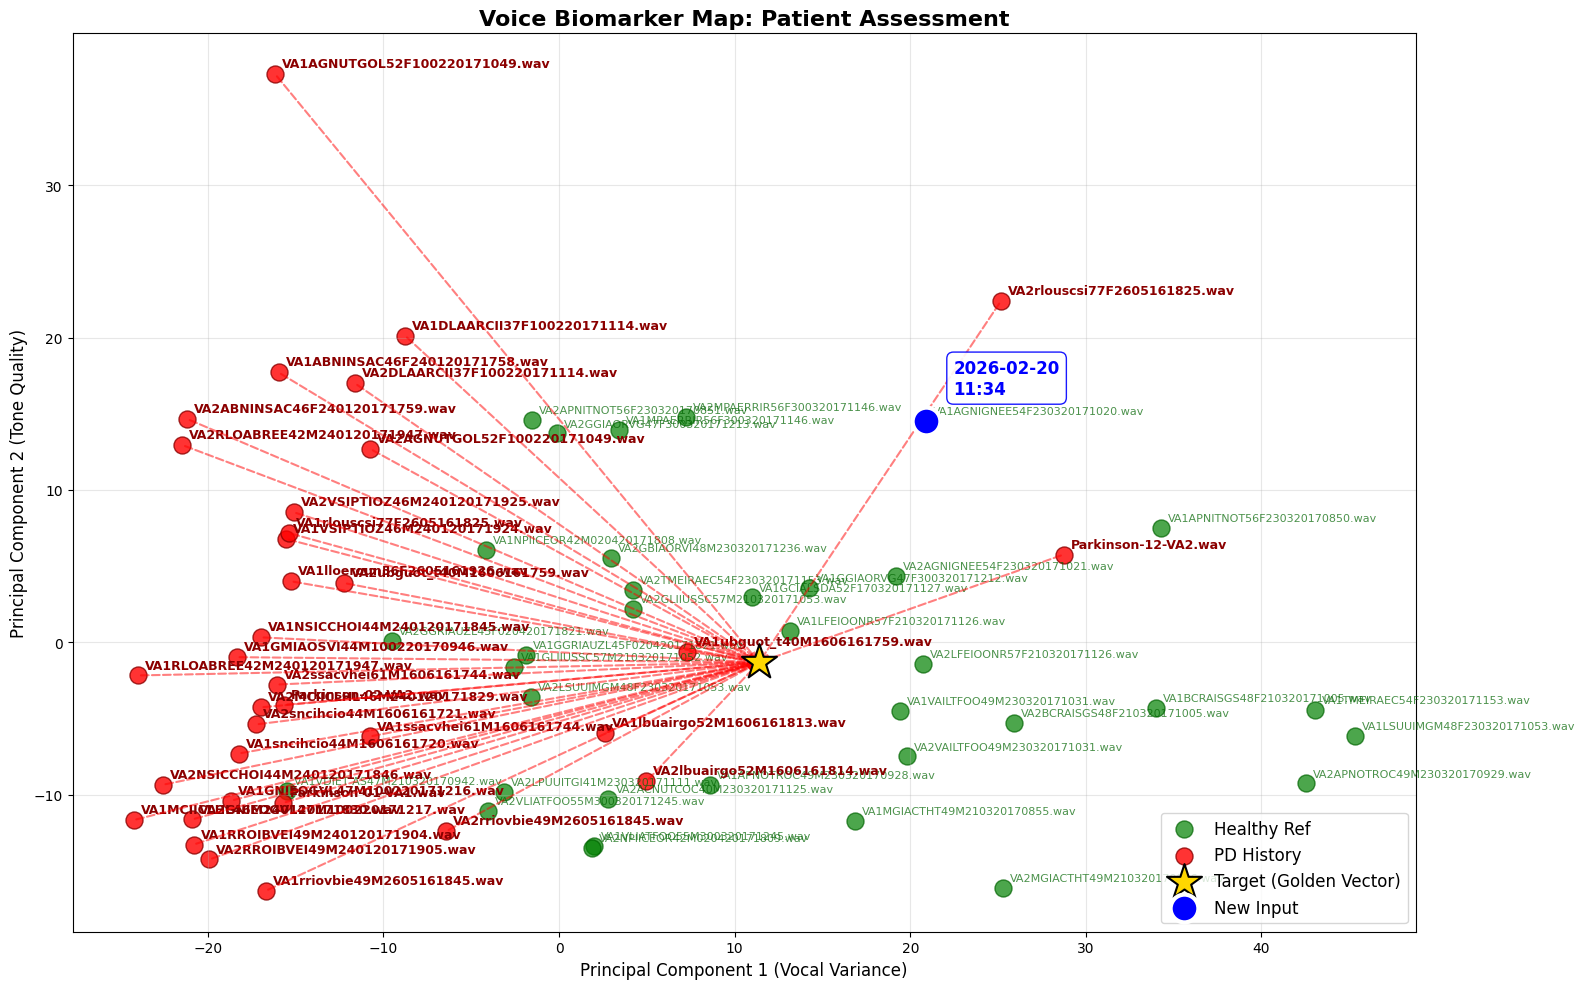

In [ ]:
# Cell 11: Main Program: Progression Monitoring Dashboard (1): PCA Clustering Map
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import parselmouth
from parselmouth.praat import call
##from transformers import Wav2Vec2Processor, Wav2Vec2Model
import glob
import os
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from datetime import datetime

##
## Steve: cut it here! The following codes are for plotting Cluster Map!!
##
plt.figure(figsize=(16, 10)) # Made figure slightly larger for labels

# 1. Background Clusters
plt.scatter(healthy_2d[:, 0], healthy_2d[:, 1], c='green', alpha=0.7, s=150, edgecolors='darkgreen', label='Healthy Ref')
plt.scatter(pd_2d[:, 0], pd_2d[:, 1], c='red', alpha=0.8, s=150, edgecolors='darkred', label='PD History')

# 2. LABELS FOR ALL DOTS (NEW)
# Healthy Labels
for i, txt in enumerate(healthy_labels):
    plt.annotate(txt, (healthy_2d[i, 0], healthy_2d[i, 1]),
                 xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7, color='darkgreen')

# PD Labels
for i, txt in enumerate(patient_labels):
    plt.annotate(txt, (pd_2d[i, 0], pd_2d[i, 1]),
                 xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold', color='darkred')

# 3. Golden Vector
plt.scatter(gold_2d[0], gold_2d[1], c='gold', s=700, marker='*', edgecolors='black', linewidth=1.5, zorder=15, label='Target (Golden Vector)')

# 4. RED ARROWS (PD History -> Gold) (UPDATED)
# Using `arrowprops` to draw red arrows pointing to the star
for pt in pd_2d:
    plt.annotate("",
                 xy=(gold_2d[0], gold_2d[1]), xycoords='data', # Head of arrow (Target)
                 xytext=(pt[0], pt[1]), textcoords='data',     # Tail of arrow (Source)
                 arrowprops=dict(arrowstyle="->", color='red', linestyle='--', linewidth=1.5, alpha=0.5))

# 5. The New Person (Blue Dot)
plt.scatter(new_2d[0], new_2d[1], c='blue', s=400, edgecolors='white', linewidth=3, zorder=20, label='New Input')

# Label with Date/Time
plt.annotate(current_time_label, (new_2d[0], new_2d[1]),
             xytext=(20, 20), textcoords='offset points',
             fontsize=12, weight='bold', color='blue',
             bbox=dict(boxstyle="round,pad=0.4", fc="white", alpha=0.9, ec="blue"))

plt.title("Voice Biomarker Map: Patient Assessment", fontsize=16, weight='bold')
plt.xlabel("Principal Component 1 (Vocal Variance)", fontsize=12)
plt.ylabel("Principal Component 2 (Tone Quality)", fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 6. GENERATE PLOT 2: UPDATED DASHBOARD ---
final_distances = patient_distances + [new_dist]
final_jitters = patient_jitters + [new_jit]
final_shimmers = patient_shimmers + [new_shim]
final_labels = patient_labels + [current_time_label]

##fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), sharex=True)
##days_axis = range(1, len(final_distances) + 1)

# Main Program: Progression Monitoring Dashboard (2)

Sorted Table (Descending by Distance, '2026' labels appended at the end in original order):


,Label,Distance from Golden Vector,Jitter,Shimmer,Predicted motor_UPDRS
0,VA1AGNUTGOL52F100220171049.wav,62.558586,2.015330,6.637478,9.334563
1,Parkinson-12-VA2.wav,49.518204,0.669022,10.032238,9.777681
2,VA2RLOABREE42M240120171947.wav,46.931210,0.424364,3.056419,10.211126
3,VA1ABNINSAC46F240120171758.wav,45.963932,0.326674,1.757442,25.681343
4,VA1MCIICLHL46M240120171830.wav,45.736546,0.339321,1.450558,27.993681
5,VA1RLOABREE42M240120171947.wav,44.413544,0.429483,3.036813,10.134668
6,Parkinson-02-VA2.wav,43.313786,0.351562,4.651352,21.538006
7,VA2ABNINSAC46F240120171759.wav,43.034584,0.236845,1.473648,9.451956
8,VA2VSIPTIOZ46M240120171925.wav,42.785271,0.724738,5.125554,8.890729
9,VA2rlouscsi77F2605161825.wav,42.202843,0.751094,6.694122,8.247795


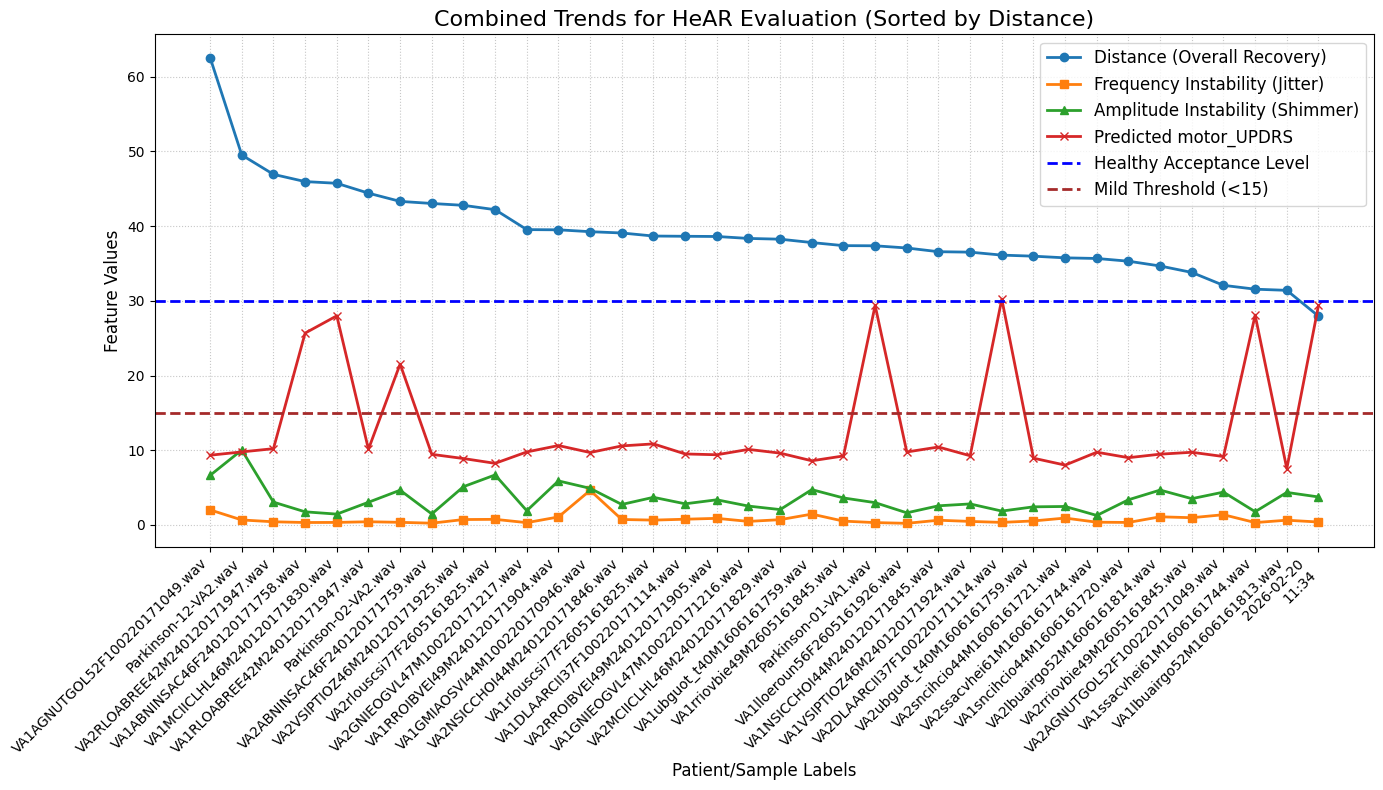

In [ ]:
# Cell 12: Main Program: Progression Monitoring Dashboard (2):
# 4 plots in one graph: AI distance, Jitter, Shimmer, moor_UPDRS score
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# 1. Combine all variables into a single dictionary, then create a DataFrame
data = {
    'Label': final_labels,
    'Distance from Golden Vector': final_distances,
    'Jitter': final_jitters,
    'Shimmer': final_shimmers,
    'Predicted motor_UPDRS': final_updrs_scores
}
df = pd.DataFrame(data)

# 2. Custom Sorting:
# Separate the '2026' records from the rest
mask_2026 = df['Label'].astype(str).str.startswith('2026')
df_2026 = df[mask_2026].copy()
df_rest = df[~mask_2026].copy()

# Sort ONLY the non-2026 records descending by distance
df_rest_sorted = df_rest.sort_values(by='Distance from Golden Vector', ascending=False)

# Recombine: Sorted records first, followed by the '2026' records in their original order
df_sorted = pd.concat([df_rest_sorted, df_2026]).reset_index(drop=True)

# Display the final custom sorted table
print("Sorted Table (Descending by Distance, '2026' labels appended at the end in original order):")
display(df_sorted)

# 3. Merge all 4 plots into one single plot
plt.figure(figsize=(14, 8))

# Plot each trend on the same axis
plt.plot(df_sorted.index, df_sorted['Distance from Golden Vector'], label='Distance (Overall Recovery)', marker='o', linewidth=2)
plt.plot(df_sorted.index, df_sorted['Jitter'], label='Frequency Instability (Jitter)', marker='s', linewidth=2)
plt.plot(df_sorted.index, df_sorted['Shimmer'], label='Amplitude Instability (Shimmer)', marker='^', linewidth=2)
plt.plot(df_sorted.index, df_sorted['Predicted motor_UPDRS'], label='Predicted motor_UPDRS', marker='x', linewidth=2)

# Add the two requested dashed horizontal lines
plt.axhline(y=30, color='blue', linestyle='--', linewidth=2, label='Healthy Acceptance Level')
plt.axhline(y=15, color='brown', linestyle='--', linewidth=2, label='Mild Threshold (<15)')

# Formatting the plot
plt.title('Combined Trends for HeAR Evaluation (Sorted by Distance)', fontsize=16)
plt.xlabel('Patient/Sample Labels', fontsize=12)
plt.ylabel('Feature Values', fontsize=12)

# Set the x-ticks to be the actual labels from your data
plt.xticks(ticks=df_sorted.index, labels=df_sorted['Label'], rotation=45, ha='right')

plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()

# Show the merged plot
plt.show()

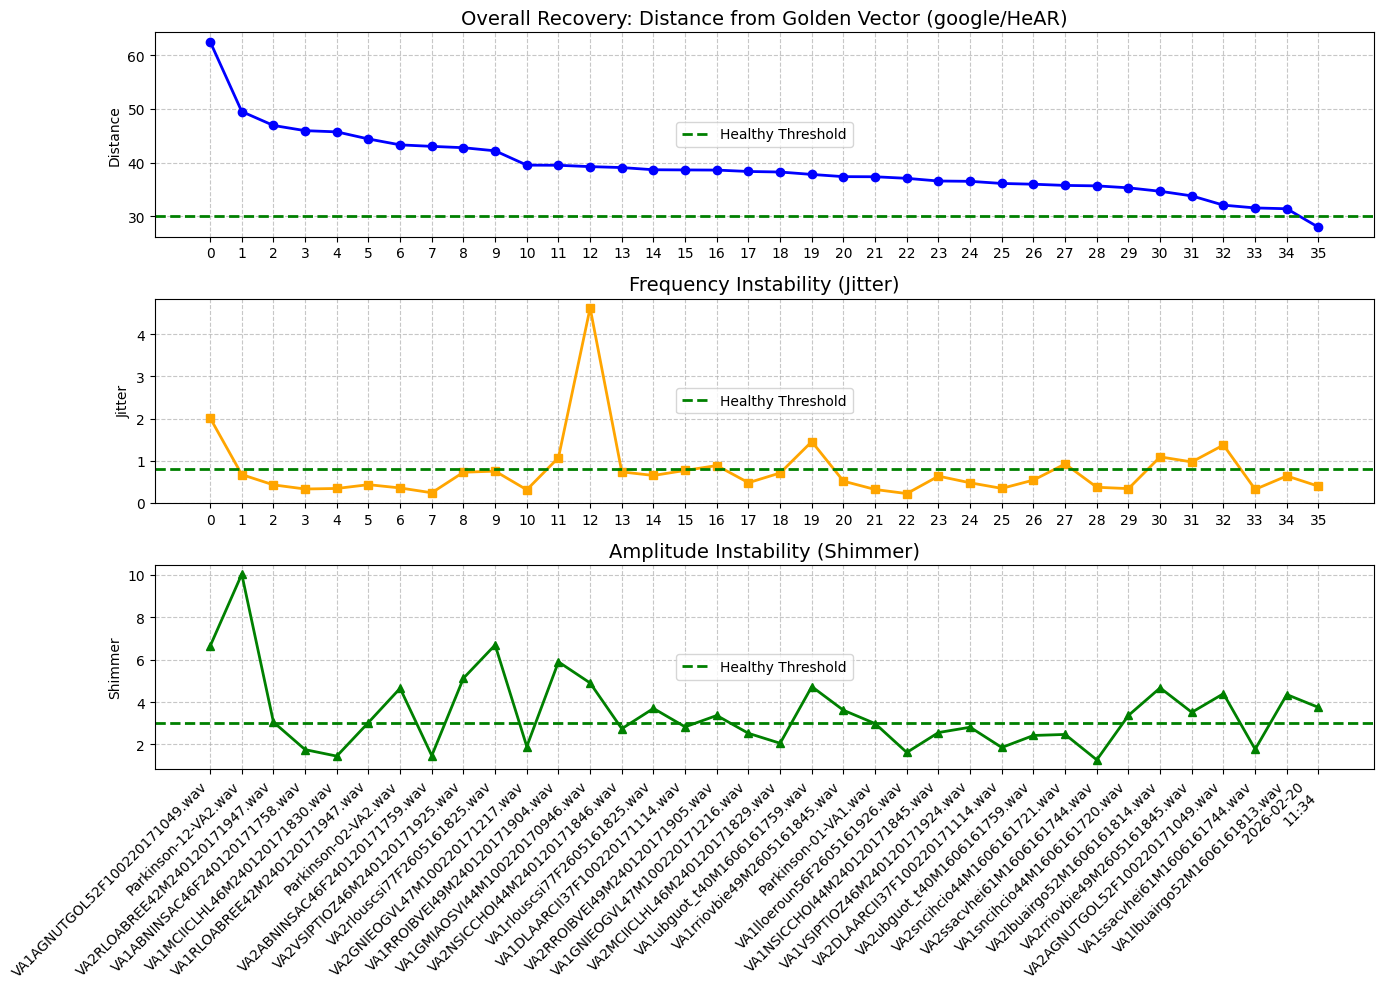

In [ ]:
# Cell 13: Main Program: Progression Monitoring Dashboard (3):
# 3 plots: AI distance, Jitter, Shimmer
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

##display(df_sorted)

# 3. Draw 4 separated and different plots using the sorted, original data
## fig, axes = plt.subplots(2, 1, figsize=(14, 20))
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# --- Plot 1: Distance from Golden Vector ---
axes[0].plot(df_sorted.index, df_sorted['Distance from Golden Vector'], marker='o', color='blue', linewidth=2)
axes[0].set_title('Overall Recovery: Distance from Golden Vector (google/HeAR)', fontsize=14)
axes[0].set_ylabel('Distance')
axes[0].axhline(y=30, color='green', linestyle='--', linewidth=2, label='Healthy Threshold')
axes[0].legend(loc='center')

# --- Plot 2: Frequency Instability (Jitter) ---
axes[1].plot(df_sorted.index, df_sorted['Jitter'], marker='s', color='orange', linewidth=2)
axes[1].set_title('Frequency Instability (Jitter)', fontsize=14)
axes[1].set_ylabel('Jitter')
axes[1].axhline(y=0.8, color='green', linestyle='--', linewidth=2, label='Healthy Threshold')
axes[1].legend(loc='center')

# --- Plot 3: Amplitude Instability (Shimmer) ---
axes[2].plot(df_sorted.index, df_sorted['Shimmer'], marker='^', color='green', linewidth=2)
axes[2].set_title('Amplitude Instability (Shimmer)', fontsize=14)
axes[2].set_ylabel('Shimmer')
axes[2].axhline(y=3, color='green', linestyle='--', linewidth=2, label='Healthy Threshold')
axes[2].legend(loc='center')

# --- Plot 4: Predicted motor_UPDRS ---
##axes[3].plot(df_sorted.index, df_sorted['Predicted motor_UPDRS'], marker='x', color='red', linewidth=2)
##axes[3].set_title('Predicted motor_UPDRS', fontsize=14)
##axes[3].set_ylabel('UPDRS Score')
##axes[3].set_xlabel('Patient/Sample Labels', fontsize=14)

# Apply unified formatting to all 4 subplots
'''for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.7)
    # Ensure X-axis shows the sorted labels properly
    ax.set_xticks(ticks=df_sorted.index)
    ax.set_xticklabels(labels=df_sorted['Label'], rotation=45, ha='right')'''

axes[0].grid(True, linestyle='--', alpha=0.7)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[2].grid(True, linestyle='--', alpha=0.7)
# Ensure X-axis shows the sorted labels properly
axes[0].set_xticks(ticks=df_sorted.index)
axes[1].set_xticks(ticks=df_sorted.index)
axes[2].set_xticklabels(labels='', rotation=45, ha='right')
axes[2].set_xticks(ticks=df_sorted.index)
axes[2].set_xticklabels(labels=df_sorted['Label'], rotation=45, ha='right')

# Adjust layout to prevent overlapping labels and titles
plt.tight_layout()

# Render the 4 distinct plots
plt.show()

In [ ]:
import pandas as pd
from IPython.display import display

# Save the sorted dataframe to a CSV file
# Setting index=False prevents pandas from writing the row indices as a separate column in the file
df_sorted.to_csv("data_for_4_plots.csv", index=False)

print("Successfully saved 'data_for_4_plots.csv'")

# Load the data back from the CSV file into a new variable
df_sorted_back = pd.read_csv("data_for_4_plots.csv")

print("Successfully loaded 'data_for_4_plots.csv' into df_sorted_back:")
# Display the first few rows to verify it loaded correctly
display(df_sorted_back.head())

Successfully saved 'data_for_4_plots.csv'
Successfully loaded 'data_for_4_plots.csv' into df_sorted_back:


,Label,Distance from Golden Vector,Jitter,Shimmer,Predicted motor_UPDRS
0,VA1AGNUTGOL52F100220171049.wav,62.558586,2.015330,6.637478,9.334563
1,Parkinson-12-VA2.wav,49.518204,0.669022,10.032238,9.777681
2,VA2RLOABREE42M240120171947.wav,46.931210,0.424364,3.056419,10.211126
3,VA1ABNINSAC46F240120171758.wav,45.963932,0.326674,1.757442,25.681343
4,VA1MCIICLHL46M240120171830.wav,45.736546,0.339321,1.450558,27.993681


In [ ]:
df = pd.DataFrame(healthy_vectors)
df.to_csv("healthy_vectors.csv", index=False)
healthy_vectors_back = pd.read_csv("healthy_vectors.csv")
healthy_vectors_back = healthy_vectors_back.values.tolist()

In [ ]:
df = pd.DataFrame(pd_vectors)
df.to_csv("pd_vectors.csv", index=False)
pd_vectors_back = pd.read_csv("pd_vectors.csv")
pd_vectors_back = pd_vectors_back.values.tolist()